In [18]:
from __future__ import annotations
import operator
import os
import re
from datetime import date, timedelta
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch

In [19]:
load_dotenv()

True

In [20]:
class Task(BaseModel):
    id: int
    title: str
    goal: str = Field(..., description='One sentence describing what the reader should be able to do/understand after this section.')
    bullets: List[str] = Field(..., min_length=3, max_length=5, description='3–5 concrete, non-overlapping subpoints to cover in this section.')
    target_words: int = Field(..., description='Target word count for this section (120–450)')
    section_type: Literal["intro", "core", "examples", "checklist", "common_mistakes", "conclusion"] = Field(
        ...,
        description="Use 'common_mistakes' exactly once in the plan.",
    )
    # Additional fields referenced in worker_node
    tags: List[str] = Field(default_factory=list, description='Tags for this section')
    requires_research: bool = Field(default=False, description='Whether this section requires research')
    requires_citations: bool = Field(default=False, description='Whether this section requires citations')
    requires_code: bool = Field(default=False, description='Whether this section requires code examples')

class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal['open_book', 'closed_book', 'hybrid']
    queries: list[str] = Field(default_factory=list)

# %%
class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None
    snippet: Optional[str] = None
    source: Optional[str] = None

# Defining the pydantic class
class Plan(BaseModel):
    blog_title: str = Field(description="Title of the blog")
    audience: str = Field(description='Who this blog is for')
    tone: str = Field(description='writing tone (example : crisp,moody,practical ...)')
    tasks: List[Task] = Field(description='breaks the task into sections')
    # Additional fields referenced in worker_node
    blog_kind: str = Field(default="tutorial", description='Type of blog (tutorial, news_roundup, etc.)')
    constraints: str = Field(default="", description='Any additional constraints for the blog')

class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(description="This will collect the information regarding the queries")

class ImageSpec(BaseModel):
    placeholder: str = Field(..., description="e.g. [[IMAGE_1]]")
    filename: str = Field(..., description="Save under images/, e.g. qkv_flow.png")
    alt: str
    caption: str
    prompt: str = Field(..., description="Prompt to send to the image model.")
    size: Literal["1024x1024", "1024x1536", "1536x1024"] = "1024x1024"
    quality: Literal["low", "medium", "high"] = "medium"

class GlobalImagePlan(BaseModel):
    md_with_placeholders: str  # FIXED: Added missing field
    merged_blog_image_tags: str  # FIXED: Corrected typo from "mereged"
    images: List[ImageSpec] = Field(default_factory=list)

In [21]:
class BlogWriter(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # Hitl
    approved : bool

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)
    final: str

    # Merging
    merge_md:str
    image_labels_content:str
    image_spe:list[dict]
    final:str

In [22]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [23]:
ROUTER_SYSTEM = """You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 3–10 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""

def router(state: BlogWriter) -> dict:
    topic = state['topic']
    decider = llm.with_structured_output(RouterDecision)
    result = decider.invoke([
        SystemMessage(content=ROUTER_SYSTEM),
        HumanMessage(content=f'topic: {topic}')
    ])

    return {
        "needs_research": result.needs_research,
        "mode": result.mode,
        "queries": result.queries,
    }

# Conditional checking 
def route_next(state: BlogWriter) -> Literal['research', 'orchestrator']:
    if state['needs_research']:
        return 'research'
    else:
        return 'orchestrator'

In [24]:
# This we have used as a tool tabily Search 
def tavily_search(query: str, max_results: int = 5) -> List[dict]:
    """Searches Tavily for relevant webpages"""
    tool = TavilySearchResults(max_results=max_results)
    result = tool.invoke({'query': query})
    normalised: List[dict] = []

    # TavilySearchResults returns a list of dicts
    if isinstance(result, list):
        for r in result:
            if isinstance(r, dict):
                normalised.append({
                    'title': r.get('title') or r.get('name') or '',
                    'url': r.get('url') or '',
                    'snippet': r.get('content') or r.get('snippet') or '',
                    'published_at': r.get('published_date') or r.get('published_at'),
                    'source': r.get('source'),
                })
    elif isinstance(result, str):
        # If it returns a string, treat it as a single result
        normalised.append({
            'title': query,
            'url': '',
            'snippet': result,
            'published_at': None,
            'source': 'tavily',
        })

    return normalised

RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
"""

def research_node(state: BlogWriter) -> dict:
    queries = (state.get('queries', []) or [])
    max_results = 6

    raw_results: List[dict] = []

    for q in queries:
        raw_results.extend(tavily_search(q, max_results=max_results))

    if not raw_results:
        return {'evidence': []}

    extractor = llm.with_structured_output(EvidencePack)
    pack = extractor.invoke([
        SystemMessage(content=RESEARCH_SYSTEM),
        HumanMessage(content=f"Raw results:\n{raw_results}")
    ])

    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e
    
    return {'evidence': list(dedup.values())}


In [25]:
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 5–9 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 3–6 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""

def orchestrator(state: BlogWriter) -> dict:
    planner = llm.with_structured_output(Plan)

    evidence = state.get('evidence', [])
    mode = state.get('mode', 'closed_book')

    plan = planner.invoke(
        [
            SystemMessage(content=ORCH_SYSTEM),
            HumanMessage(
                content=(
                    f"Topic: {state['topic']}\n"
                    f"Mode: {mode}\n\n"
                    f"Evidence (ONLY use for fresh claims; may be empty):\n"
                    f"{[e.model_dump() for e in evidence][:16]}"
                )
            ),
        ]
    )

    return {"plan": plan}

In [26]:
def hitl(state: BlogWriter) -> dict:
    plan = state['plan']
    assert plan is not None
    print("Sections:")

    for t in plan.tasks:
        print(f"ID: {t.id} | Title: {t.title}")
    
    decision = input("\nApprove this plan? (y/n): ").strip().lower()

    if decision == "y":
        return {"approved": True}
    else:
        print("You can modify topic and rerun.")
        return {"approved": False}

In [27]:
def hitl_review(state:BlogWriter)->Literal['worker',END]:
    if state['approved']:
        return 'worker'
    else:
        return END

In [28]:
def fanout(state: BlogWriter):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [29]:
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id, section_md)]}

In [30]:
def merging_content(state: BlogWriter) -> dict:
    plan = state['plan']
    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    merged_md = f"# {plan.blog_title}\n\n{body}\n"
    return {"merged_md": merged_md}


DECIDE_IMAGES_SYSTEM = """You are an expert technical editor.
Decide if images/diagrams are needed for THIS blog.

Rules:
- Max 3 images total.
- Each image must materially improve understanding (diagram/flow/table-like visual).
- Insert placeholders exactly: [[IMAGE_1]], [[IMAGE_2]], [[IMAGE_3]].
- If no images needed: md_with_placeholders must equal input and images=[].
- Avoid decorative images; prefer technical diagrams with short labels.
Return strictly GlobalImagePlan.
"""

def decide_images(state: BlogWriter) -> dict:
    
    planner = llm.with_structured_output(GlobalImagePlan)
    merged_md = state["merged_md"]
    plan = state["plan"]
    assert plan is not None

    image_plan = planner.invoke(
        [
            SystemMessage(content=DECIDE_IMAGES_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Topic: {state['topic']}\n\n"
                    "Insert placeholders + propose image prompts.\n\n"
                    f"{merged_md}"
                )
            ),
        ]
    )

    return {
        "md_with_placeholders": image_plan.md_with_placeholders,
        "image_specs": [img.model_dump() for img in image_plan.images],
    }

def _gemini_generate_image_bytes(prompt: str) -> bytes:
    """
    Returns raw image bytes generated by Gemini.
    Requires: pip install google-genai
    Env var: GOOGLE_API_KEY
    """
    from google import genai
    from google.genai import types

    api_key = os.environ.get("GOOGLE_API_KEY")
    if not api_key:
        raise RuntimeError("GOOGLE_API_KEY is not set.")

    client = genai.Client(api_key=api_key)

    resp = client.models.generate_content(
        model="gemini-2.5-flash-image",
        contents=prompt,
        config=types.GenerateContentConfig(
            response_modalities=["IMAGE"],
            safety_settings=[
                types.SafetySetting(
                    category="HARM_CATEGORY_DANGEROUS_CONTENT",
                    threshold="BLOCK_ONLY_HIGH",
                )
            ],
        ),
    )

    # Depending on SDK version, parts may hang off resp.candidates[0].content.parts
    parts = getattr(resp, "parts", None)
    if not parts and getattr(resp, "candidates", None):
        try:
            parts = resp.candidates[0].content.parts
        except Exception:
            parts = None

    if not parts:
        raise RuntimeError("No image content returned (safety/quota/SDK change).")
    for part in parts:
        inline = getattr(part, "inline_data", None)
        if inline and getattr(inline, "data", None):
            return inline.data

    raise RuntimeError("No inline image bytes found in response.")

def generate_and_place_images(state: BlogWriter) -> dict:

    plan = state["plan"]
    assert plan is not None

    md = state.get("md_with_placeholders") or state["merged_md"]
    image_specs = state.get("image_specs", []) or []

    # If no images requested, just write merged markdown
    if not image_specs:
        filename = f"{plan.blog_title}.md"
        Path(filename).write_text(md, encoding="utf-8")
        return {"final": md}

    images_dir = Path("images")
    images_dir.mkdir(exist_ok=True)

    for spec in image_specs:
        placeholder = spec["placeholder"]
        filename = spec["filename"]
        out_path = images_dir / filename

        # generate only if needed
        if not out_path.exists():
            try:
                img_bytes = _gemini_generate_image_bytes(spec["prompt"])
                out_path.write_bytes(img_bytes)
            except Exception as e:
                # graceful fallback: keep doc usable
                prompt_block = (
                    f"> **[IMAGE GENERATION FAILED]** {spec.get('caption','')}\n>\n"
                    f"> **Alt:** {spec.get('alt','')}\n>\n"
                    f"> **Prompt:** {spec.get('prompt','')}\n>\n"
                    f"> **Error:** {e}\n"
                )
                md = md.replace(placeholder, prompt_block)
                continue

        img_md = f"![{spec['alt']}](images/{filename})\n*{spec['caption']}*"
        md = md.replace(placeholder, img_md)

    filename = f"{plan.blog_title}.md"
    Path(filename).write_text(md, encoding="utf-8")
    return {"final": md}

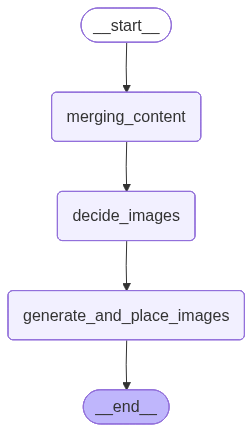

In [31]:
# build reducer subgraph
reducer_graph = StateGraph(BlogWriter)
reducer_graph.add_node("merging_content", merging_content)
reducer_graph.add_node("decide_images", decide_images)
reducer_graph.add_node("generate_and_place_images", generate_and_place_images)
reducer_graph.add_edge(START, "merging_content")
reducer_graph.add_edge("merging_content", "decide_images")
reducer_graph.add_edge("decide_images", "generate_and_place_images")
reducer_graph.add_edge("generate_and_place_images", END)
reducer_subgraph = reducer_graph.compile()

reducer_subgraph

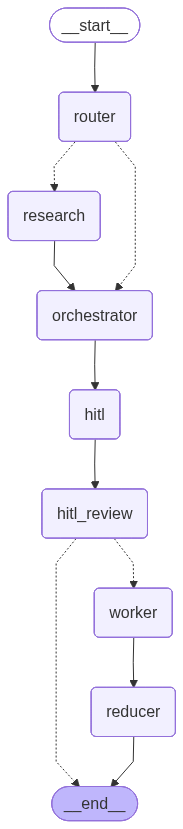

In [ ]:
graph = StateGraph(BlogWriter)

graph.add_node('router', router)
graph.add_node('research', research_node)
graph.add_node('orchestrator', orchestrator)
graph.add_node('hitl', hitl)
graph.add_node('hitl_review', hitl_review)
graph.add_node('worker', worker_node)
graph.add_node('reducer', reducer_subgraph)

graph.add_edge(START, 'router')
graph.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
graph.add_edge("research", "orchestrator")
graph.add_edge('orchestrator', 'hitl')
graph.add_edge('hitl', 'hitl_review')
graph.add_conditional_edges('hitl_review', hitl_review, {'worker': 'worker', END: END})  # FIXED: Proper conditional edges
graph.add_edge('worker', 'reducer')
graph.add_edge('reducer', END)

workflow = graph.compile()
workflow

In [33]:
def run(topic: str):
    out = workflow.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

    return out